# Multi-step inference
> with cn-initialization single-cell strategy

In [21]:
import torch
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

import scgenome.plotting as pl

import simul
from utils.tree_utils import tree_to_newick
from tests.utils_testing import get_tree_K_nodes_one_level
from utils.config import Config, set_seed
from variational_distributions.joint_dists import FixedTreeJointDist
from variational_distributions.var_dists import qMuTau, qCMultiChrom, qZ, qEpsilonMulti, qPi
%matplotlib inline

set_seed(101)

In [22]:
M = 500
K = 5
A = 6
N = 200
n_datasets = 2

# set params
a0 = 20.
b0 = 1000.

nu0 = 1.
lambda0 = 10.
alpha0 = 500.
beta0 = 50.
# less variable baseline
#alpha0 = 2500.
#beta0 = 50.

delta0 = 10.


simulating dataset...


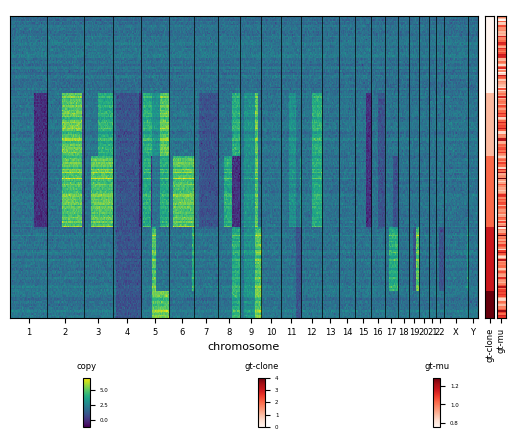

In [3]:
# simulate datasets
print("simulating dataset...")
config = Config(n_cells=N, n_nodes=K, n_states=A, chain_length=M, debug=True, step_size=0.08, wis_sample_size=50)
# for dsi in range(n_datasets):
fix_joint_q, sim_adata = simul.generate_dataset_var_tree(config, chrom='real', ret_anndata=True,
                                                         nu_prior=nu0, lambda_prior=lambda0, 
                                                         alpha_prior=alpha0, beta_prior=beta0,
                                                         eps_a=a0, eps_b=b0, dir_alpha=delta0)

sim_adata.obs['gt-clone'] = fix_joint_q.z.true_params['z'].numpy()
sim_adata.layers['state'] = fix_joint_q.c.true_params['c'].numpy()[sim_adata.obs['gt-clone']]
sim_adata.obs['gt-mu'] = fix_joint_q.mt.true_params['mu'].numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'copy', annotation_fields=['gt-clone', 'gt-mu'], cell_order_fields=['gt-clone'], raw=True)

Fig: simulated reads together with true clustering and baseline.

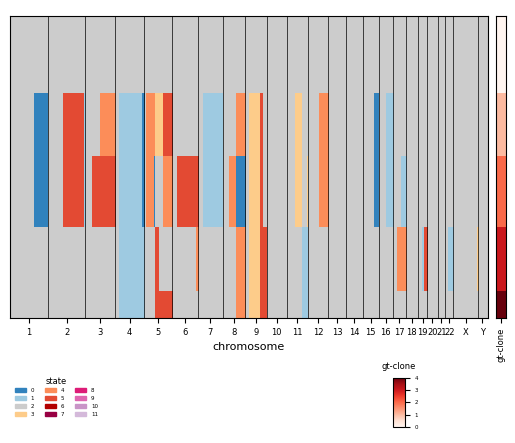

In [4]:
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'state', annotation_fields=['gt-clone'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

Fig. True copy number signal for each cluster.

In [5]:
# set up qmt, cell-qc
cell_config = Config(n_cells=N, n_nodes=N+1, n_states=A, step_size=0.08,
                     chain_length=config.chain_length, chromosome_indexes=config.chromosome_indexes, debug=True)
cell_qmt = qMuTau(cell_config, nu_prior=1., lambda_prior=100., alpha_prior=5000., beta_prior=200.)
cell_qmt.initialize(method='prior')

cell_qc = qCMultiChrom(cell_config)
cell_qc.initialize(method='diploid')

cell_qeps = qEpsilonMulti(cell_config, alpha_prior=1., beta_prior=10.)
cell_qeps.initialize(method='fixed-equal', eps_alpha=cell_config.chain_length / 100, eps_beta=cell_config.chain_length)

In [6]:
# run inference with qmt,cell-qc
fixed_z = torch.arange(1, N + 1)
cell_qz_fix = qZ(cell_config, true_params={'z': fixed_z})
cell_tree = get_tree_K_nodes_one_level(N + 1)

print("running inference...")
for i in range(60):
    cell_qmt.update(cell_qc, cell_qz_fix, fix_joint_q.obs)
    cell_qc.update(fix_joint_q.obs, cell_qeps, cell_qz_fix, cell_qmt,
                   [cell_tree], [1.])
    cell_qeps.update([cell_tree], torch.tensor([1.]), cell_qc)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {cell_qc.compute_elbo([cell_tree], [1.], q_eps=cell_qeps)}")


running inference...
it 9, elbo -68254.97973632812
it 19, elbo -73759.93566894531
it 29, elbo -84306.94445800781
it 39, elbo -87903.02160644531
it 49, elbo -88162.11199951172
it 59, elbo -87381.22082519531


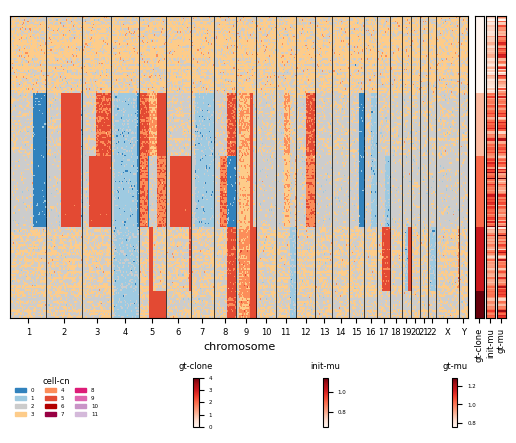

In [7]:
# after inference on cells specific cn
sim_adata.layers['cell-cn'] = cell_qc.get_viterbi()[1:].numpy()
sim_adata.obs['init-mu'] = cell_qmt.nu.numpy()[torch.arange(N), torch.arange(1, N+1)]
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'cell-cn', annotation_fields=['gt-clone', 'init-mu', 'gt-mu'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

Fig. Cell-specific copy number profile when qMuTau and cell-qC are jointly inferred for initialization

In [8]:
print("running k-means")
# cluster copy numbers with kmeans (on viterbi)
kmeans = KMeans(n_clusters=K, random_state=0).fit(cell_qc.get_viterbi()[1:])
c_labels = kmeans.labels_

print(f"ARI for KMeans after cell-cn estimation: {adjusted_rand_score(c_labels, fix_joint_q.z.true_params['z'].numpy())}")

# cluster copy numbers with kmeans (on viterbi)
obs_kmeans = KMeans(n_clusters=K, random_state=0).fit(fix_joint_q.obs.T.numpy())
obs_labels = obs_kmeans.labels_

print(f"ARI for KMeans with obs: {adjusted_rand_score(obs_labels, fix_joint_q.z.true_params['z'].numpy())}")


running k-means
ARI for KMeans after cell-cn estimation: 1.0
ARI for KMeans with obs: 1.0


In [9]:
# initialize new qc with average
# build eta1 and eta2 from cell_qc
qc = qCMultiChrom(config)

for i, chr_qc in enumerate(qc.qC_list):
    # init for each chromosome the average tensor
    avg_param = {'eta1': torch.empty_like(chr_qc.eta1), 'eta2': torch.empty_like(chr_qc.eta2)}
    for k in range(K):
        cells_k = c_labels == k
        # average of eta parameters over cells assigned to the same cluster
        avg_param['eta1'][k, ...] = cell_qc.qC_list[i].eta1[1:][cells_k].mean(dim=0)
        avg_param['eta2'][k, ...] = cell_qc.qC_list[i].eta2[1:][cells_k].mean(dim=0)
    # normalization step
    avg_param['eta1'] = avg_param['eta1'] - torch.logsumexp(avg_param['eta1'], dim=-1, keepdim=True)
    avg_param['eta2'] = avg_param['eta2'] - torch.logsumexp(avg_param['eta2'], dim=-1, keepdim=True)

    chr_qc.initialize(method='fixed', **avg_param)

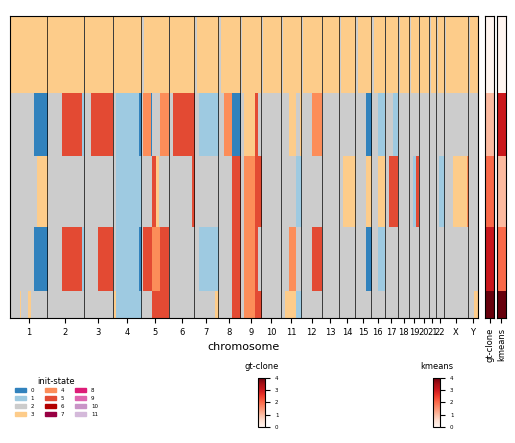

In [10]:
# inspect current state of new qC
sim_adata.layers['init-state'] = qc.get_viterbi().numpy()[sim_adata.obs['gt-clone']]
sim_adata.obs['kmeans'] = c_labels
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'init-state', annotation_fields=['gt-clone', 'kmeans'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

In [11]:
stable_zero = 1e-2
# initialize new qz (with current clustering) and new qeps
qz = qZ(config)
pi_init = torch.nn.functional.one_hot(torch.tensor(c_labels).long(), num_classes=config.n_nodes)
pi_init_smooth = torch.empty_like(pi_init, dtype=torch.float)
pi_init_smooth[pi_init == 1] = 1 - stable_zero
pi_init_smooth[pi_init == 0] = stable_zero / (config.n_nodes - 1)
# qz.initialize(z_init='fixed', pi_init=pi_init)
qz.initialize(z_init='fixed', pi_init=pi_init_smooth)

qpi = qPi(config)
cell_counts = np.unique(c_labels, return_counts=True)[1]
concentration_param_init = torch.tensor(cell_counts)
qpi.initialize(method='fixed', concentration_param_init=concentration_param_init)

qeps = qEpsilonMulti(config, alpha_prior=a0, beta_prior=b0)
qeps.initialize(method='prior')

qmt = qMuTau(config, nu_prior=1., lambda_prior=10., alpha_prior=50., beta_prior=5.)
pair_cell_idx = torch.arange(N), torch.arange(1, N+1)
qmt.initialize(method='fixed', loc=cell_qmt.nu[pair_cell_idx][:, None],
               precision_factor=cell_qmt.lmbda[pair_cell_idx][:, None],
               shape=cell_qmt.alpha[pair_cell_idx][:, None],
               rate=cell_qmt.beta[pair_cell_idx][:, None])


In [12]:
print("few more updates for qc and qmt after clustering...")
treeK = get_tree_K_nodes_one_level(config.n_nodes)

for i in range(50):
    qc.update(fix_joint_q.obs, qeps, qz, qmt, [treeK], [1.])
    qeps.update([treeK], [1.], qc)
    qmt.update(qc, qz, fix_joint_q.obs)

few more updates for qc and qmt after clustering...


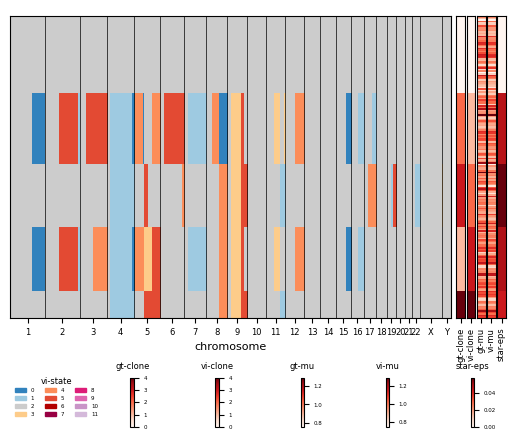

In [13]:
sim_adata.obs['vi-clone'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-clone']]
sim_adata.obs['vi-mu'] = qmt.nu.numpy()[torch.arange(N), sim_adata.obs['vi-clone']]

# analyze eps
eps_mean_K = [qeps.mean()[0,k].item() for k in range(1, config.n_nodes)]
eps_mean_K = np.array([0.] + eps_mean_K)
sim_adata.obs['star-eps'] = eps_mean_K[sim_adata.obs['vi-clone']]

g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu', 'star-eps'], cell_order_fields=['vi-clone'], max_cn=7)

In [14]:
print("running inference post init...")
joint = FixedTreeJointDist(config, qc, qz, qeps, qmt, qpi, treeK, fix_joint_q.obs)
for i in range(100):
    joint.update(it = i)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {joint.elbo}")
        

running inference post init...
it 9, elbo -145010.828125
it 19, elbo -144687.921875
it 29, elbo -144271.703125
it 39, elbo -144092.984375
it 49, elbo -144036.8125
it 59, elbo -144029.046875
it 69, elbo -144032.359375
it 79, elbo -144034.875
it 89, elbo -144049.421875
it 99, elbo -144043.3125


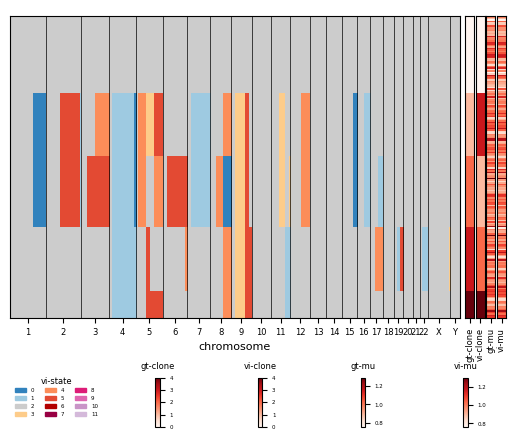

In [15]:
sim_adata.obs['vi-clone'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-clone']]
sim_adata.obs['vi-mu'] = qmt.nu.numpy()[torch.arange(N), sim_adata.obs['vi-clone']]
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu'], cell_order_fields=['gt-clone'], max_cn=7)

## ISSUE

No cells are assigned to the healthy clone, and similar clusters are confounded.
When running qMuTau and cell-qC jointly in the beginning, it's easy for the algorithm
to find optima in mu that are smaller/larger than the true mu, while offsetting the
copy number accordingly. This can be avoided by using HMMcopy profile instead as an
initialization step.

## attempts

- initializing epsilon to low values slows down convergence: due to small step-size
  it takes time for eps_a and eps_b to reach stable values which scale with M.
  *Sol*: initialize to larger values using M as scale
- qc also should not be randomly initialized because that will drive the epsilon
  parameters to values for which the mean is large (around 0.5) in the first inference steps
  
## one solution
Initializing the copy number profiles to (smoothed) diploid profile helps in avoiding
the initial drift to wrong eps params!
initializing qC to random or even uniform markov transitions is a really bad initialization,
because it will drive epsilon to reach larger values due to the enormous number of copy 
number changes. This leads to the first inference step where epsilon goes up until when 
it stabilizes and then the copy numbers will decrease the number of changes by following
the data and so epsilon will slowly drop again.

## Tree inference
We now inspect the resulting epsilon values and from those, we try to infer the tree

In [16]:
from variational_distributions.var_dists import qT
from variational_distributions.joint_dists import VarTreeJointDist

qt = qT(config)
qt.initialize()

print("updating qt and qeps jointly")
for i in range(30):
    qt.update(qc, qeps)
    tlist, wtens = qt.get_trees_sample()
    qeps.update(tlist, wtens, qc)
    if i % 5 == 0:
        print(f"it: {i}, qt elbo: {qt.compute_elbo()}")
    

updating qt and qeps jointly
it: 0, qt elbo: -2.823532819747925
it: 5, qt elbo: -2.8877902030944824
it: 10, qt elbo: -3.021728038787842
it: 15, qt elbo: -3.313222885131836
it: 20, qt elbo: -3.5914907455444336
it: 25, qt elbo: -3.708099365234375


In [17]:
full_q = VarTreeJointDist(config, fix_joint_q.obs, qc, qz, qeps=qeps, qmt=qmt, qpi=qpi,
                          qt=qt)

for i in range(100):
    full_q.update()
    if i % 5 == 0:
        print(f"it: {i}, qt elbo: {full_q.compute_elbo()}")


it: 0, qt elbo: -145626.1875
it: 5, qt elbo: -145633.1875
it: 10, qt elbo: -145646.03125
it: 15, qt elbo: -145636.6875
it: 20, qt elbo: -145626.1875
it: 25, qt elbo: -145632.921875
it: 30, qt elbo: -145624.734375
it: 35, qt elbo: -145624.46875
it: 40, qt elbo: -145625.59375
it: 45, qt elbo: -145626.109375
it: 50, qt elbo: -145636.1875
it: 55, qt elbo: -145623.84375
it: 60, qt elbo: -145635.953125
it: 65, qt elbo: -145623.515625
it: 70, qt elbo: -145623.4375
it: 75, qt elbo: -145627.46875
it: 80, qt elbo: -145638.71875
it: 85, qt elbo: -145628.0625
it: 90, qt elbo: -145629.09375
it: 95, qt elbo: -145624.625


In [18]:
from utils.evaluation import best_mapping
import networkx as nx

# remap clones
mapping = best_mapping(gt_z=fix_joint_q.z.true_params['z'].numpy(), vi_z=full_q.z.pi.numpy())

remapped_true_tree = nx.relabel_nodes(fix_joint_q.t.true_params['tree'], {a: b for a, b in enumerate(mapping)})


In [19]:
qt_dict = full_q.t.get_pmf_estimate(normalized=True, desc_sorted=True, n=500)
true_nwk = tree_to_newick(remapped_true_tree) 
print(f"true tree: {true_nwk}, p: {qt_dict[true_nwk]}")

print("tree dist")
for t, p in qt_dict.items():
    print(t)
    print(p)
    print("-----")

true tree: ((1,(3)2)4)0, p: 0.0037903201300650835
tree dist
((((3)1)4)2)0
tensor(0.0192)
-----
((((2)4)3)1)0
tensor(0.0185)
-----
(1,((4)3)2)0
tensor(0.0162)
-----
(((4)1,2)3)0
tensor(0.0161)
-----
(((4)1)2,3)0
tensor(0.0158)
-----
((2,4)1,3)0
tensor(0.0152)
-----
((1)2,(3)4)0
tensor(0.0146)
-----
((((1)4)2)3)0
tensor(0.0145)
-----
(2,((4)1)3)0
tensor(0.0143)
-----
((1,(3)4)2)0
tensor(0.0135)
-----
(((2,3)4)1)0
tensor(0.0130)
-----
(2,(1,3)4)0
tensor(0.0130)
-----
((3)1,(4)2)0
tensor(0.0127)
-----
((((1)2)3)4)0
tensor(0.0127)
-----
(2,((1)3)4)0
tensor(0.0126)
-----
((1,2,3)4)0
tensor(0.0125)
-----
(2,(1,4)3)0
tensor(0.0125)
-----
(((1,4)3)2)0
tensor(0.0124)
-----
((3)1,(2)4)0
tensor(0.0123)
-----
((((4)3)2)1)0
tensor(0.0122)
-----
((1,4)2,3)0
tensor(0.0120)
-----
(((3)4)1,2)0
tensor(0.0119)
-----
((((2)1)3)4)0
tensor(0.0118)
-----
(((1)2,3)4)0
tensor(0.0116)
-----
(((1,3)4)2)0
tensor(0.0114)
-----
((1,3,4)2)0
tensor(0.0114)
-----
((((4)2)3)1)0
tensor(0.0113)
-----
(((3)1,2)4)0
tensor(0

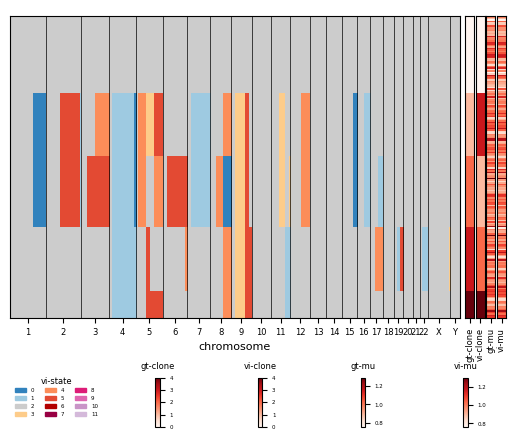

In [20]:
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu'], cell_order_fields=['gt-clone'], max_cn=7)

## Final considerations

The tree still is not correctly estimated and definitely not certain enough on a small set of topologies.
The probability mass is spread over many topologies making downstream tree-reconstruction task difficult.

After the last updates, two (similar) clones are also merged together.
This may suggest few things:
- qt was not updated long enough while qc and qz are fixed, resulting in an uncertain qt which then
destabilize the already good copy number signal and clone assignment
- qt needs a better initialization possibly coming from the epsilon values that were already
inferred in the previous update steps
- a different step size for the final update could work better